Here I'm evaluating how well matrix factorization can work at predicting cross-assay bioactivities from ChEMBL.  Specifically, I'm using training/test sets provided by Eric Martin.

The idea is we have a matrix where the rows are unique compounds and the columns are unique assays.  The matrix is sparse and we want to predict the missing values.

First I'm going to investigate straightforward MF and then, hopefully, experiment with different loss functions and including chemical fingerprints in the matrix.

In [2]:
import numpy as np
import pandas as pd
import glob,re,sys
import matplotlib.pyplot as plt
%matplotlib inline

TomDLT implemented support for missing value imputation, but it doesn't look like it has been merged in yet so using it directly (https://github.com/scikit-learn/scikit-learn/pull/8474)

In [3]:
import nmf

In [4]:
randomtrain = pd.read_csv('chemble-splits/random.train')
randomtest = pd.read_csv('chemble-splits/random.test')
realtrain = pd.read_csv('chemble-splits/realistic.train')
realtest = pd.read_csv('chemble-splits/realistic.test')

In [5]:
#map assay/cmpd ids to indices
assayids = dict()
cmpdids = dict()
idx2cmpd = []
idx2assay = []
for table in [randomtrain, randomtest, realtrain, realtest]: #presumably redundant
    for r in table.iterrows():
        if r[1].ID not in cmpdids:
            cmpdids[r[1].ID] = len(cmpdids)
            idx2cmpd.append(r[1].ID)
        if r[1].AssayID not in assayids:
            assayids[r[1].AssayID] = len(assayids)
            idx2assay.append(r[1].AssayID)

In [6]:
len(cmpdids),len(assayids)

(13190, 159)

In [7]:
def makematrix(data, cmpdids, assayids):
    ret = np.full((len(cmpdids),len(assayids)),np.nan)
    for (rid, row) in data.iterrows():
        r = cmpdids[row.ID]
        c = assayids[row.AssayID]
        ret[r][c] = row.pIC50_exp
    return ret

In [8]:
randomtrain_m = makematrix(randomtrain,cmpdids,assayids)
realtrain_m = makematrix(realtrain,cmpdids,assayids)

In [67]:
#let's see what happens with the defaults
model = nmf.NMF(solver='mu',max_iter=300) #mu required for missing value support
W = model.fit_transform(randomtrain_m)
H = model.components_

nmf.py:1169: ConvergenceWarning: Maximum number of iteration 300 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [68]:
W.shape,H.shape

((13190, 159), (159, 159))

In [90]:
def getpred(pred, data, cmpdids, assayids):
    '''return tuples of (true value, predicted value)'''    
    ret = []
    for (ri, row) in data.iterrows():
        i = cmpdids[row.ID]
        j = assayids[row.AssayID]
        pval = pred[i][j]
        ret.append((row.pIC50_exp,pval))
    return np.array(ret)

In [91]:
pred = np.matmul(W,H)
trainpred = getpred(pred,randomtrain, cmpdids, assayids)
testpred = getpred(pred,randomtest,cmpdids,assayids)

In [92]:
print "Pearson R, train =",np.corrcoef(trainpred.T)[0][1],"test =",np.corrcoef(testpred.T)[0][1]

Pearson R, train = 0.988833933768 test = 0.320250426287


Clearly we are overfitting..

(0, 12)

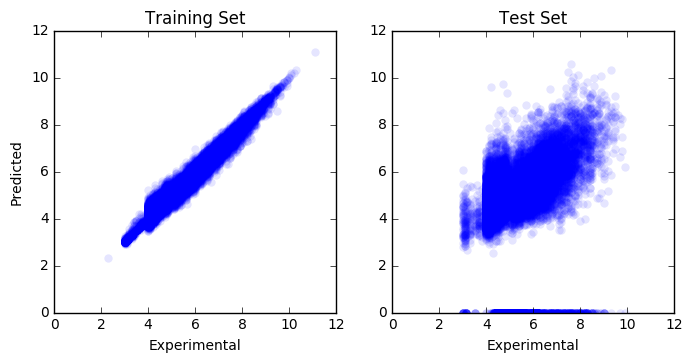

In [93]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(trainpred[:,0],trainpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Training Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpred[:,0],testpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_title("Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

Huh, so actually if you remove the zero-predicted values it's not so bad...

In [100]:
from sklearn.metrics import mean_squared_error
testnotzero = testpred[testpred[:,1] > 0]
print "Pearson R =",np.corrcoef(testnotzero.T)[0][1],"RMSE", mean_squared_error(testnotzero[:,0],testnotzero[:,1])

 Pearson R = 0.70079172885 RMSE 0.615338902088


90% are non-zero

In [98]:
len(testnotzero)/float(len(testpred))

0.9007293639105126

So what happens if we optimize the model parameters?
 * *alpha* - amount of regularization (default 0)
 * *l1_ratio* - L1 vs L2 ratio, default 0 is all L2
 * *n_components* - number of components (default all) 

In [106]:
#this takes a loooong time despite being a rather course grid search
results = []
for alpha in [0,0.01,1]:
    for l1_ratio in [0,0.5,1]:
            for ncomponents in range(9,160,10):
                model = nmf.NMF(solver='mu',alpha=alpha,l1_ratio=l1_ratio,n_components=ncomponents,init='random')
                W = model.fit_transform(randomtrain_m)
                H = model.components_
                pred = np.matmul(W,H)
                trainpred = getpred(pred,randomtrain, cmpdids, assayids)
                testpred = getpred(pred,randomtest,cmpdids,assayids)
                testnotzero = testpred[testpred[:,1] > 0]
                trainR = np.corrcoef(trainpred.T)[0][1]
                testR = np.corrcoef(testpred.T)[0][1]
                testRnz = np.corrcoef(testnotzero.T)[0][1]

                trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
                testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
                testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])
                results.append((alpha,l1_ratio,ncomponents,trainR,trainRMS, testR,testRMS, testRnz,testRMSnz))
                

In [107]:
gridres = pd.DataFrame(results,columns=['alpha','l1_ratio','ncomponents','trainR','trainRMS','testR','testRMS','testRnz','testRMSnz'])

In [115]:
gridres.sort_values('testRnz',ascending=False)

,alpha,l1_ratio,ncomponents,trainR,trainRMS,testR,testRMS,testRnz,testRMSnz
17,0.00,0.5,19,0.897496,0.218757,0.351062,3.135017,0.749154,0.525687
49,0.01,0.0,19,0.895893,0.221999,0.345007,3.133474,0.746757,0.523973
48,0.01,0.0,9,0.853846,0.304600,0.336436,3.128160,0.746074,0.518074
64,0.01,0.5,9,0.853457,0.305363,0.336124,3.130627,0.744815,0.520812
80,0.01,1.0,9,0.847685,0.316377,0.332914,3.128409,0.744811,0.518350
0,0.00,0.0,9,0.852756,0.306677,0.333619,3.137728,0.740821,0.528697
32,0.00,1.0,9,0.851275,0.309530,0.332239,3.141158,0.738713,0.532504
65,0.01,0.5,19,0.894742,0.224290,0.347199,3.156005,0.737909,0.548988
16,0.00,0.5,9,0.850804,0.310448,0.331108,3.146233,0.735873,0.538139
1,0.00,0.0,19,0.892909,0.227987,0.341230,3.156323,0.735633,0.549341


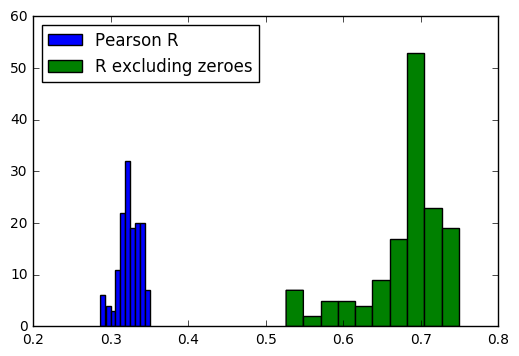

In [120]:
plt.hist(gridres.testR,label="Pearson R")
plt.hist(gridres.testRnz,label="R excluding zeroes")
plt.legend(loc='best')

Interestingly, the best models didn't use L1/L2 regularization (alpha=0) but had a limited number of components (which is probably also effective at preventing overfitting).

In [129]:
secondresults = []
for ncomponents in range(5,60,5):
    model = nmf.NMF(solver='mu',n_components=ncomponents,init='random')
    W = model.fit_transform(randomtrain_m)
    H = model.components_
    pred = np.matmul(W,H)
    trainpred = getpred(pred,randomtrain, cmpdids, assayids)
    testpred = getpred(pred,randomtest,cmpdids,assayids)
    testnotzero = testpred[testpred[:,1] > 0]
    trainR = np.corrcoef(trainpred.T)[0][1]
    testR = np.corrcoef(testpred.T)[0][1]
    testRnz = np.corrcoef(testnotzero.T)[0][1]

    trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
    testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
    testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])
    secondresults.append((ncomponents,trainR,trainRMS, testR,testRMS, testRnz,testRMSnz))

In [130]:
grid2res = pd.DataFrame(secondresults,columns=['ncomponents','trainR','trainRMS','testR','testRMS','testRnz','testRMSnz'])

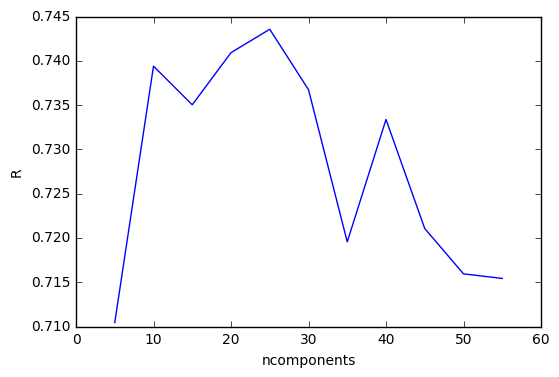

In [131]:
plt.plot(grid2res.ncomponents,grid2res.testRnz,label='Excluding zeroes')
plt.xlabel('ncomponents')
plt.ylabel('R')

So something like 25 components for this dataset.. now let's see how we do with the realistic set.

In [132]:
model = nmf.NMF(solver='mu',n_components=25,init='random')
W = model.fit_transform(realtrain_m)
H = model.components_
pred = np.matmul(W,H)
trainpred = getpred(pred,realtrain, cmpdids, assayids)
testpred = getpred(pred,realtest,cmpdids,assayids)
testnotzero = testpred[testpred[:,1] > 0]
trainR = np.corrcoef(trainpred.T)[0][1]
testR = np.corrcoef(testpred.T)[0][1]
testRnz = np.corrcoef(testnotzero.T)[0][1]

trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])

(0, 12)

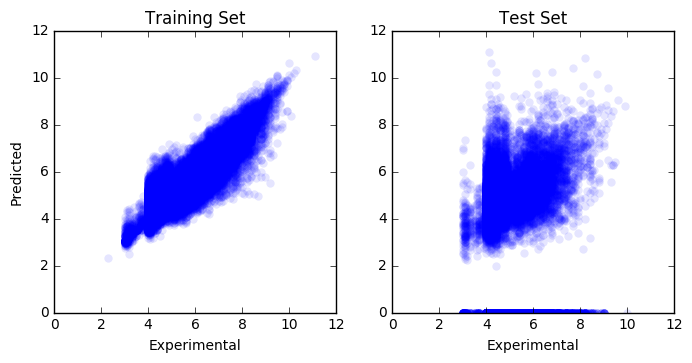

In [133]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(trainpred[:,0],trainpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Training Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpred[:,0],testpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_title("Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

In [134]:
print "Pearson R =",np.corrcoef(testnotzero.T)[0][1],"RMSE", mean_squared_error(testnotzero[:,0],testnotzero[:,1])

Pearson R = 0.47169590548 RMSE 0.959472833936


In [135]:
len(testnotzero)/float(len(testpred))

0.6933227859480062

As expected, we do worse and there are more zeroes (presumably cases where there simply isn't information in the training set on the assay or compound).


So what happens if we add fingerprints to the matrix?  This would let the model tie data together using chemical similarity, however traditional matrix factorization is unlikely to be ideal as the same norm is applied to the whole matrix despite the matrix containing two very different types of data (fingerprint bits and affinities).

Nonetheless, let's see what happens.